# Análise Modal para Resposta Forçada em Sistemas com Amortecimento

### Condições de análise: $$\text{Sistema Subamortecido } (0 \leq \zeta \geq 1)$$

In [1]:
#Importando bibliotecas:
import numpy as np
from sympy import *
from sympy.integrals.heurisch import heurisch
import warnings
import matplotlib.pyplot as plt

#Cores dos gráficos:
color = ['red', 'green', 'blue', 'cyan', 'orange', 'm', 'yellow', 'black', 'purple', 'pink']

#Exibição dos gráficos em no notebook:
%matplotlib inline

'''
#Exibição dos gráficos em janela externa:
%matplotlib qt
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 20
'''

# Inicializações importantes:
warnings.filterwarnings("ignore")
init_printing()

# Função de arredondar elemento da matriz:
def arredNUM(matrix):
    for a in preorder_traversal(matrix):
        if isinstance(a, Float):
            matrix = matrix.subs(a, round(a, 4))
    return matrix

$$[M]\ddot{x} - [C]\dot{x} + [K]x = [F]$$

Jazar - Eq. (11.46)

<img src="images/exemplo.png">

### Definição das matrizes (Lagrange) e condições iniciais:

In [2]:
# Matriz das massas (Kg):
M = np.array([
    [4, 0, 0],
    [0, 4, 0],
    [0, 0, 4]
])

# Matriz de rigidez (N/m):
K = np.array([
    [8, -4, 0], 
    [-4, 8, -4], 
    [0, -4, 4]
])

# Matriz de amortecimento (N*s/m) ou (Kg/s):
C = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
])

# Matriz de coeficientes de amortecimento - zeta (transposta):
#Z = np.array([-1, -1, -1]).T
Z = np.array([0.9, 0.2, 0.4]).T

# Matriz de posições iniciais (transposta):
X0 = np.array([1, 2, 0.5]).T

# Matriz de velocidades iniciais (transposta):
V0 = np.array([0, 0, 0]).T

x = Symbol('x')
# Matriz de F(x) (transposta):
#F = np.array([0, 0, 0]).T
F = np.array([sin(x), cos(x), exp(-x)]).T

### $$\text{Obtenção de } [M]^{-1/2}:$$

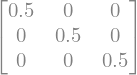

In [3]:
MM = np.power(M, -1/2) # Inverso da raíz quadrada

MM[MM == np.inf] = 0 # Transforma os elementos infinitos em zero

Matrix(MM)

### $$ \text{Cálculo da matriz } \tilde{[K]} = [M^{-1/2}][K][M^{-1/2}]:$$

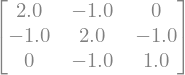

In [4]:
K_til = MM@K@MM # Cálculo da matriz K_til

Matrix(K_til)

### $$ \text{Cálculo da matriz } \tilde{[C]} = [M^{-1/2}][C][M^{-1/2}]:$$

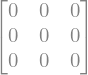

In [5]:
C_til = MM@C@MM # Cálculo da matriz C_til

Matrix(C_til)

### $$\text{Obtendo os autovalores (} \lambda \text{) e autovetores normalizados (} P \text{) de }\tilde{[K]}:$$

In [6]:
lamb, P = np.linalg.eig(K_til) # Obtenção dos autovalores e autovetores normalizados

##### $$\text{Matriz de autovalores }[\lambda]:$$

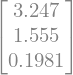

In [7]:
Matrix(lamb.round(4))

##### $$\text{Matriz de autovetores normalizados }[P]:$$

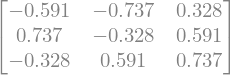

In [8]:
Matrix(P.round(4))

### Cálculo das frequências naturais: $$[\omega_n] = \left[ \sqrt{\lambda} \right]$$

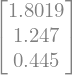

In [9]:
omega_n = np.sqrt(lamb) # Calcula a matriz de freqências naturais, em rad/s

Matrix(omega_n.round(4))

### $$\text{Cálculo da matriz } [S] = [M^{-1/2}][P]$$

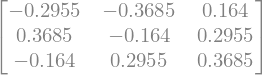

In [10]:
S = MM@P # Cálcula a matriz S

Matrix(S.round(4))

### $$\text{Cálculo da matriz } [\Lambda] = [P^T][\tilde{K}][P]$$

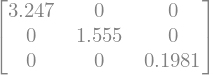

In [11]:
LAMB = P.T@K_til@P # Calcula a matriz LAMBDA, que deve ser igual à matriz diagonal contendo os autovalores

Matrix(LAMB.round(4))

### $$\text{Cálculo da matriz } [\Gamma] = [P^T][\tilde{C}][P]$$

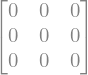

In [12]:
GAM = P.T@C_til@P # Calcula a matriz GAMMA, que deve ser igual à matriz diagonal contendo os coeficientes de amortecimento em r

Matrix(GAM.round(4))

### $$\text{Determinando os coeficientes de amortecimento } \zeta_i:$$

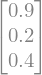

In [13]:
if(Z[0]==-1):
    for i in range(len(omega_n)):
        Z[i] = (GAM[i][i]/(2*np.sqrt(LAMB[i][i])))

Matrix(Z)

### Cálculo das frequências amortecidas: $$[\omega_d] = \left[ \omega_n\sqrt{1-\zeta^2} \right]$$

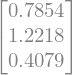

In [14]:
omega_d = omega_n*np.sqrt(1-np.power(Z, 2)) # Calcula a matriz de freqências amortecidas, em rad/s

Matrix(omega_d.round(4))

### Transformações de coordenadas das condições iniciais: $$[X_0], [V_0] ~~\rightarrow~~ [R_o], [\dot{R_0}]$$

##### $$\text{Matriz de posição }[X_0] \rightarrow [R_0]:$$

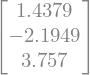

In [15]:
R0 = np.linalg.inv(S)@X0 # Conversão de coordenadas para posição

Matrix(R0.round(4))

##### $$\text{Matriz de velocidade }[V_0] \rightarrow [\dot{R_0}]:$$

In [16]:
RD0 = np.linalg.inv(S)@V0 # Conversão de coordenadas para velocidade

Matrix(RD0.round(4))

### Obter soluções modais desacopladas do tipo: $$r_i(t) = A_ie^{-\zeta_i\omega_it}sen(\omega_{d_i}t+\phi_i)+\frac{1}{\omega_{d_i}}e^{-\zeta_i\omega_it}\int_0^t \left( f_i(\tau)e^{\zeta_i\omega_i\tau}sen(\omega_{d_i}(t-\tau)) \right)d\tau$$

### $$\text{Cálculo de } A_i = \sqrt{\frac{(r_{0_i}\omega_{d_i})^2+(\dot{r_{0_i}}+\zeta_i\omega_ir_{0_i})^2}{\omega_{d_i}^2}}:$$

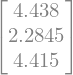

In [17]:
A = np.sqrt((np.power((R0*omega_n), 2)+np.power((RD0+(Z*omega_n*R0)), 2))/np.power(omega_d, 2)) #Cálculo da matriz de amplitudes

Matrix(A.round(4))

### $$\text{Cálculo de } \phi_i = tan^{-1}\left( \frac{r_{o_i}\omega_{d_i}}{\dot{r_0}_i+\zeta_i\omega_ir_{0_i}} \right):$$

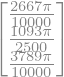

In [18]:
ph = np.arctan((R0*omega_n)/(RD0+(Z*omega_n*R0))) # Cálculo da matriz de fases, em radianos

PHI = []

for i in ph: #Ajuste para evitar erros de aproximação do ponto flutuante
    PHI.append(nsimplify(round((i/np.pi), 4)*pi))

Matrix(PHI)

### Montando as expressões:

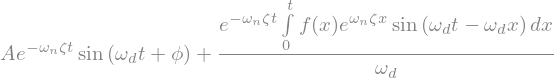

In [19]:
# Definição da forma geral da solução:
a = Symbol('A')
omgn = Symbol('\omega_n')
omgd = Symbol('\omega_d')
phi = Symbol('\phi')
f = Function('f')(x)
z = Symbol('\zeta')
t = Symbol('t')

# Resposta amortecida:
damped = (a*exp(-z*omgn*t)*sin((omgd*t)+phi))

# Método Heurístico para resolução da integral indefinida e teorema fundamental do cálculo:
def itg(fun, a, b):
    exp = heurisch(fun, x)
    return simplify(exp.subs(x, b) - exp.subs(x, a))

# Resposta forçada:
def forced(function=None):
    if(function==None):
        return ((1/omgd)*exp(-z*omgn*t)*integrate((f*exp(z*omgn*x)*sin(omgd*t-omgd*x)), (x, 0, t)))
    else:
        return ((1/omgd)*exp(-z*omgn*t)*itg((function*exp(z*omgn*x)*sin(omgd*t-omgd*x)), 0, t))
    
(damped+forced())

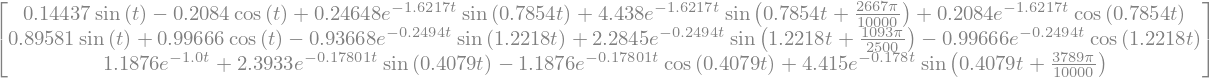

In [20]:
# Substituição das respectivas constantes em suas iterações:
RT = []
for i in range(len(omega_n)):
    ri = (damped+forced(F[i])).subs([(a, A[i]), (omgn, omega_n[i]), (phi, PHI[i]), (omgd, omega_d[i]), (z, Z[i])]).doit()
    RT.append(trigsimp(arredNUM(ri))) # Simplificação trigonométrica

Matrix(RT)

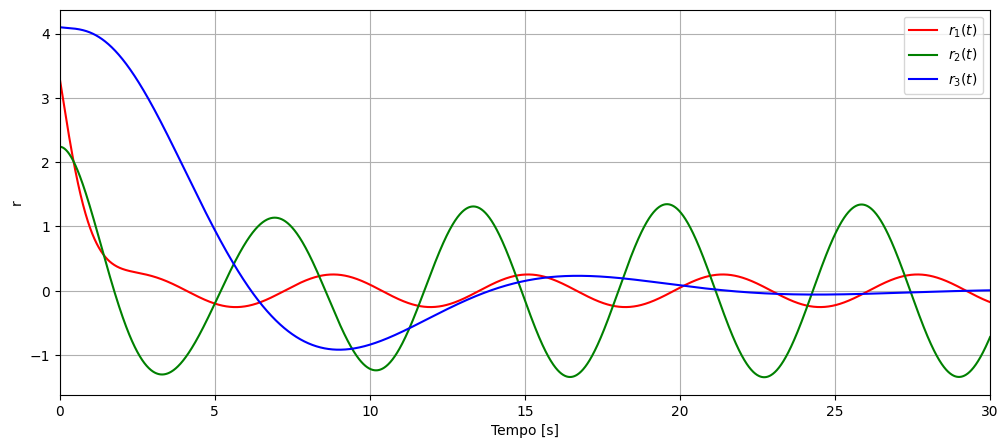

In [21]:
ts = 1e-2 #tempo de amostragem
tf = 30
time = np.arange(0, 500, ts) # Criando vetor de tempo

# Criando matriz de posição em função do tempo:
R = []
for i in RT:
    fx = lambdify(t, i, 'numpy')
    R.append(fx(time))

# Plotando os gráficos:
plt.rcParams['figure.figsize'] = (12, 5)
plt.figure(1)
for i in range(len(R)):
    plt.plot(time, R[i], color[i], label=f'$r_{i+1}(t)$')
plt.ylabel('r')
plt.legend()
plt.xlabel('Tempo [s]')
plt.title('')
plt.xlim(0, tf)
plt.grid()
plt.show()

### Retornando ao domínio físico:

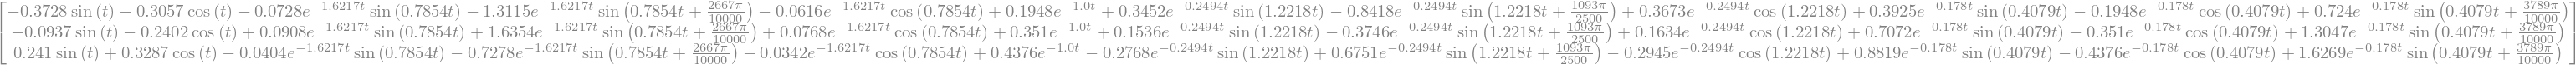

In [22]:
XT = arredNUM(Matrix(S@RT))

Matrix(XT)

### Resposta temporal:

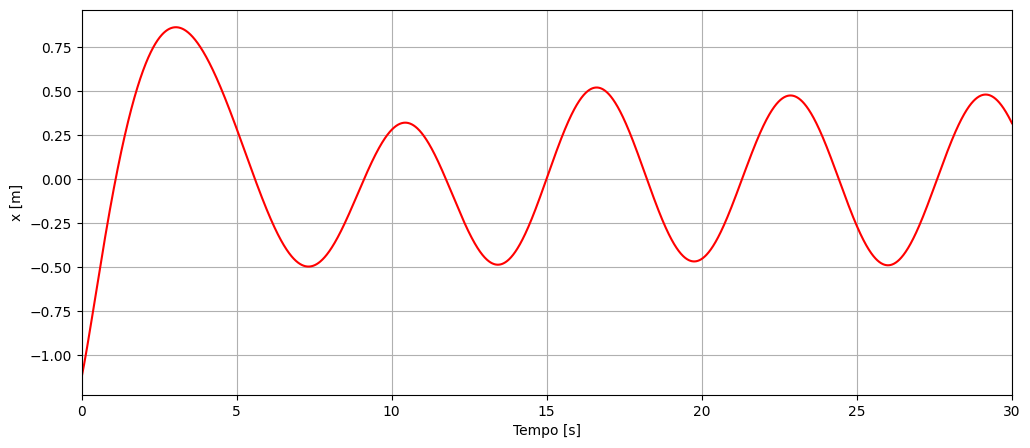

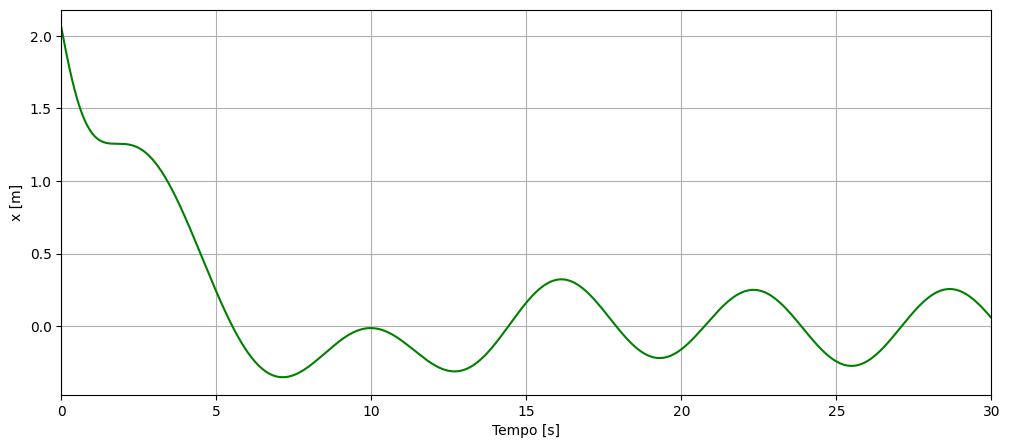

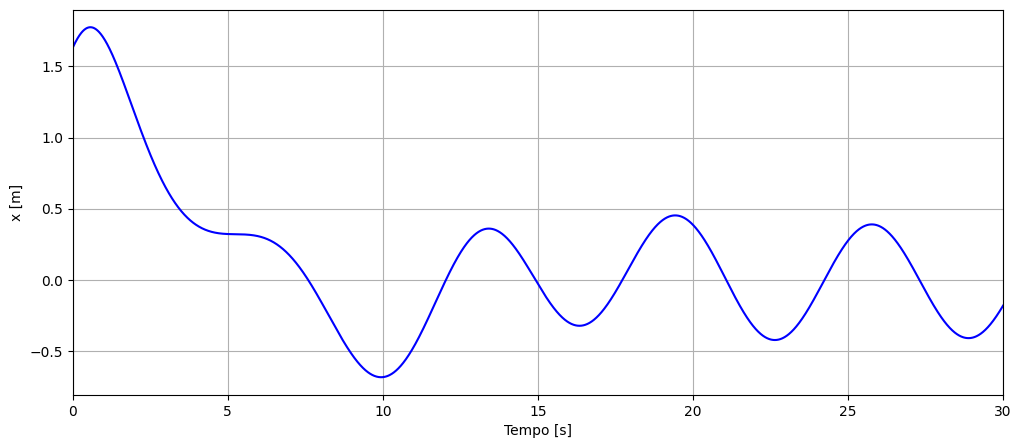

In [23]:
# Criando matriz de posição em função do tempo:
X = []
for i in XT:
    fx = lambdify(t, i, 'numpy')
    X.append(fx(time))
'''
X = []
for i in range(len(XT)):
    X.append([])
    for j in time:
        X[i].append(XT[i].subs(t, j))
'''

# Plotando os gráficos:
for i in range(len(X)):
    plt.rcParams['figure.figsize'] = (12, 5)
    plt.figure(i+2)
    plt.plot(time, X[i], color[i], label='$x(t)$')
    plt.ylabel('x [m]')
    #plt.legend()
    plt.xlabel('Tempo [s]')
    plt.title('')
    plt.xlim(0, tf)
    plt.grid()
    plt.show()


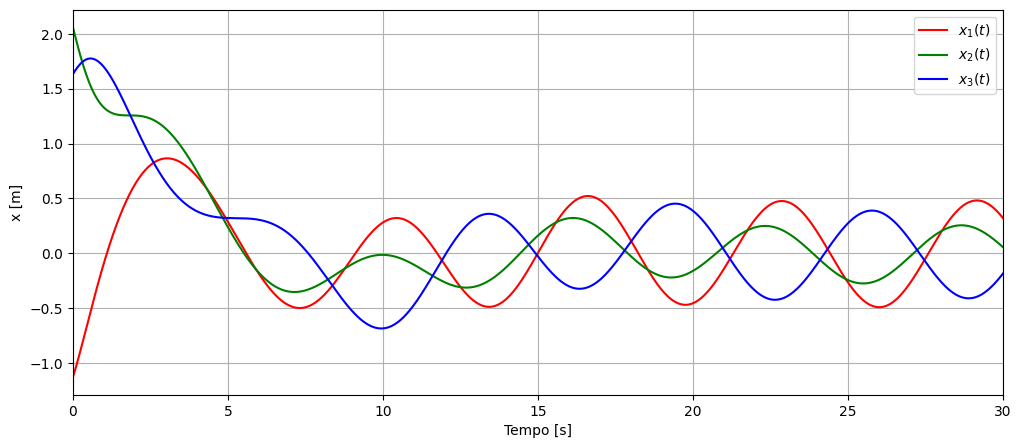

In [24]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.figure(len(omega_n)+2)
for i in range(len(X)):
    plt.plot(time, X[i], color[i], label=f'$x_{i+1}(t)$')
plt.ylabel('x [m]')
plt.legend()
plt.xlabel('Tempo [s]')
plt.title('')
plt.xlim(0, tf)
plt.grid()
plt.show()

### Frequências naturais, em Hertz:

In [25]:
for i in range(len(omega_n)):
    print(f'f{i+1} = {round((omega_n[i]/(2*np.pi)), 4)} Hz')

f1 = 0.2868 Hz
f2 = 0.1985 Hz
f3 = 0.0708 Hz


### Resposta em frequência:

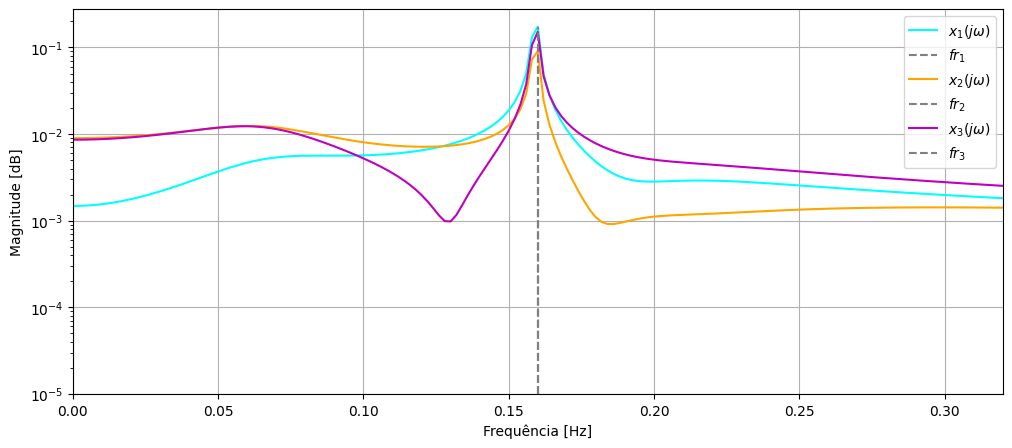

In [26]:
# Preparando as transformadas de Fourier:
def fft(sig, ts):
    fft = np.fft.fft(sig)

    N = len(sig)

    g = np.fft.fftfreq(N, ts)

    freqs = (g[:(N//2)]*(2*np.pi))
    amplitudes = (np.abs(fft)[:(N//2)]*(1/N))
    phase = np.rad2deg(np.angle(fft)[:(N//2)])

    return freqs, amplitudes, phase

ffts = []
for i in X:
    ffts.append(fft(i, ts))


# Frequências de ressonância
freqres = []
amp = []
for i in ffts:
    j = np.where(i[1]==np.max(i[1]))
    freqres.append(i[0][j][0])
    amp.append(i[1][j][0])

#Limite do eixo X, para ajuste:
xl = (np.max(freqres)/np.pi)

# Pltotando: Amplitude em função de frequência
plt.rcParams['figure.figsize'] = (12, 5)
plt.figure(len(omega_n)+3)
plt.semilogy()
for i in range(len(ffts)):
    plt.plot((ffts[i][0]/(2*np.pi)), ffts[i][1], color[i+len(omega_n)], label=f'$x_{i+1}(j\omega)$')
    plt.plot([(freqres[i]/(2*np.pi)), (freqres[i]/(2*np.pi))], [0, amp[i]], 'gray', linestyle='dashed', label=f'$fr_{i+1}$')
plt.ylabel('Magnitude [dB]')
plt.legend()
plt.xlabel('Frequência [Hz]')
plt.title('')
plt.xlim(0, xl)
plt.grid()
plt.show()

### Frequências de ressonância, em Hertz:

In [27]:
for i in range(len(freqres)):
    print(f'f{i+1} = {(freqres[i]/(2*np.pi)).round(4)} Hz')

f1 = 0.16 Hz
f2 = 0.16 Hz
f3 = 0.16 Hz
